In [5]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec


from sarjana.handlers import ParquetWaterfall

path = Path(os.getenv('DATAPATH'), 'raw', 'wfall', 'FRB20190627D_waterfall.h5.parquet')

burst = ParquetWaterfall(path)

In [ ]:
scatterfit = True

extent = [*burst.extent]
plot_time = burst.plot_time
ts = burst.ts
dt = burst.dt
wfall = burst.wfall
spec = burst.spec
plot_freq = burst.plot_freq
model_ts = burst.model_ts
model_spec = burst.model_spec

eventname = burst.eventname
dm = burst.dm

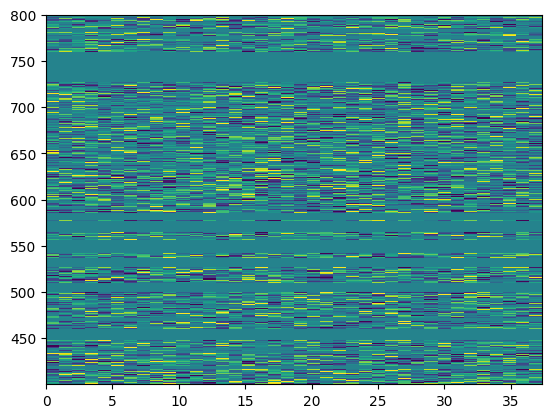

In [7]:
burst.wfall[np.isnan(burst.wfall)] = np.nanmedian(burst.wfall)

cmap = plt.cm.viridis

vmin = np.nanpercentile(burst.wfall, 1)
vmax = np.nanpercentile(burst.wfall, 99)

plt.imshow(burst.wfall, aspect="auto", interpolation="none",
                extent=burst.extent, vmin=vmin, vmax=vmax, cmap=cmap)

In [10]:
from sarjana.signal import find_burst

ts = burst.ts

peak, width, snr = find_burst(ts)

/home/tazaaznam/lab/sarjana/.venv/lib/python3.9/site-packages/cfod/analysis/waterfall.py:97: RuntimeWarning: Degrees of freedom <= 0 for slice.
  channel_variance = np.nanvar(wfall, axis=1)
/home/tazaaznam/lab/sarjana/.venv/lib/python3.9/site-packages/cfod/analysis/waterfall.py:206: RuntimeWarning: Mean of empty slice
  data = np.nanmean(


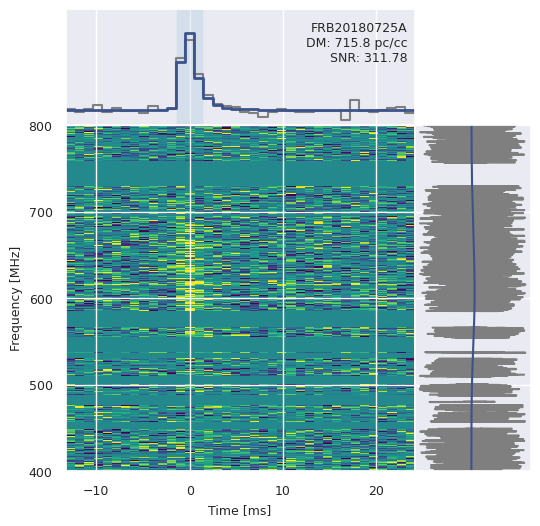

In [74]:
fig = plt.figure(figsize=(6,6))
## Set up the image grid
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios=[3, 1],
                        height_ratios=[1, 3], hspace=0.0, wspace=0.0)
data_im = plt.subplot(gs[2])
data_ts = plt.subplot(gs[0], sharex=data_im)
data_spec = plt.subplot(gs[3], sharey=data_im)


### time stamps relative to the peak
peak_idx = np.argmax(ts)
extent[0] = np.copy(extent[0] - plot_time[peak_idx])
extent[1] = np.copy(extent[1] - plot_time[peak_idx])
plot_time -= plot_time[peak_idx]

# prepare time-series for histogramming
plot_time -= dt / 2.
plot_time = np.append(plot_time, plot_time[-1] + dt)

cmap = plt.cm.viridis

### plot dynamic spectrum
wfall[np.isnan(wfall)] = np.nanmedian(wfall)   # replace nans in the data with the data median
# use standard deviation of residuals to set color scale
vmin = np.nanpercentile(wfall, 1)
vmax = np.nanpercentile(wfall, 99)

data_im.imshow(wfall, aspect="auto", interpolation="none",
                extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)

### plot time-series
data_ts.plot(plot_time, np.append(ts, ts[-1]), color="tab:gray",
                drawstyle="steps-post")

### plot spectrum
data_spec.plot(spec, plot_freq, color="tab:gray")

### plot model time-series and spectrum
if scatterfit:
    data_spec.plot(model_spec, plot_freq, color=cmap(0.25))
    data_ts.plot(plot_time, np.append(model_ts, model_ts[-1]),
                    color=cmap(0.25), drawstyle="steps-post", lw=2)
else:
    data_spec.plot(model_spec, plot_freq, color=cmap(0.5))
    data_ts.plot(plot_time, np.append(model_ts, model_ts[-1]),
                    color=cmap(0.5), drawstyle="steps-post", lw=1)


## BEautify plot
# remove some labels and ticks for neatness
plt.setp(data_ts.get_xticklabels(), visible=False)
data_ts.set_yticklabels([], visible=True)
data_ts.set_yticks([])
data_ts.set_xlim(extent[0], extent[1])
plt.setp(data_spec.get_yticklabels(), visible=False)
data_spec.set_xticklabels([], visible=True)
data_spec.set_xticks([])
data_spec.set_ylim(extent[2], extent[3])
plt.setp(data_im.get_xticklabels(), fontsize=9)
plt.setp(data_im.get_yticklabels(), fontsize=9)


#### highlighting the width of the pulse
data_ts.axvspan(max(plot_time.min(),
                        plot_time[peak] + 0.5 * dt \
                        - (0.5 * width) * dt),
                    min(plot_time.max(),
                        plot_time[peak] + 0.5 * dt \
                        + (0.5 * width) * dt),
                    facecolor="tab:blue", edgecolor=None, alpha=0.1)


##### add event ID and DM labels
xlim = data_ts.get_xlim()
ylim = data_ts.get_ylim()

# add 20% extra white space at the top
span = np.abs(ylim[1]) + np.abs(ylim[0])
data_ts.set_ylim(ylim[0], ylim[1] + 0.2 * span)
ylim = data_ts.get_ylim()

ypos = (ylim[1] - ylim[0]) * 0.9 + ylim[0]
xpos = (xlim[1] - xlim[0]) * 0.98 + extent[0]
data_ts.text(xpos, ypos, "{}\nDM: {:.1f} pc/cc\nSNR: {:.2f}".format(eventname, dm,snr), ha="right",
                va="top", fontsize=9)

data_im.locator_params(axis="x", min_n_ticks=3)
data_im.set_yticks([400, 500, 600, 700, 800])
data_im.set_ylabel("Frequency [MHz]", fontsize=9)
data_im.set_xlabel("Time [ms]", fontsize=9)